In [1]:
import sys
sys.path.insert(0,'../PLASIM/')
import Learn2_new as ln
ut = ln.ut # utilities
ef = ln.ef # ERA_Fields_New

# log to stdout
import logging
import os
logging.getLogger().level = logging.INFO
logging.getLogger().handlers = [logging.StreamHandler(sys.stdout)]

# set spacing of the indentation
ut.indentation_sep = '  '

2023-03-09 14:12:50.777330: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 14:12:50.915888: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-09 14:12:50.919651: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-09 14:12:50.919665: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [17]:
import importlib as imp
imp.reload(ln)
imp.reload(ef)

path_to_ERA = '/net/nfs/ssd1/gmiloshe/Climate-Learning'/ERA/
Could not import sliding_window_view from np.lib.stride_tricks. Using custom copy for numpy<1.20
Could not load field_infos: using the hardcoded version
Trying to import basemap
In this environment you cannot import Basemap
Trying to import cartopy
Successfully imported cartopy


<module 'ERA.ERA_Fields_New' from '/net/nfs/ssd1/gmiloshe/Climate-Learning/ERA/ERA_Fields_New.py'>

In [3]:
import xarray as xr
test = xr.open_dataset('/net/nfs/ssd1/gmiloshe/Data/CESM/Data_CESM_short/North_Anomalies_TSA.nc')
test

<xarray.Dataset>
Dimensions:    (time: 3060, bnds: 2, lon: 288, lat: 192)
Coordinates:
  * time       (time) object 0001-05-01 10:30:01 ... 0002-09-30 10:30:01
  * lon        (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat        (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    TSA        (time, lat, lon) float32 ...
Attributes: (12/19)
    CDI:                                  Climate Data Interface version 1.9....
    Conventions:                          CF-1.0
    source:                               Community Land Model CLM4.0
    history:                              Wed Feb 22 12:55:34 2023: cdo selye...
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    ...                                   ...
    Initial_conditions_dataset:           clmi.BCN.2000-01-01_0.9x1.25_gx1v6_...
    PFT_physiological_constants_dataset:  pft-physiology.clm40.c130424.nc
    Time_constant_3Dvars_filename:        ./CAM4_F2000_p144_ctrl_batch_0001.c...
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT
    frequency:                            day
    CDO:                                  Climate Data Operators version 1.9....

In [4]:
test=test.fillna(0)
test.TSA.values

array([[[ -8.257808  ,  -8.235525  ,  -8.230226  , ...,  -8.228594  ,
          -8.245183  ,  -8.220384  ],
        [ -8.810752  ,  -8.8921385 ,  -8.950834  , ...,  -8.741156  ,
          -8.721177  ,  -8.637792  ],
        [-10.04392   , -10.133607  , -10.087078  , ..., -10.525824  ,
         -10.231055  , -10.528709  ],
        ...,
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]],

       [[ -3.9305751 ,  -3.9391913 ,  -3.9557164 , ...,  -3.960745  ,
          -3.931791  ,  -3.942436  ],
        [ -3.6858072 ,  -3.717007  ,  -3.7906704 , ...,  -3.6272693 ,
          -3.6601093 ,  -3.7343354 ],
        [ -5.4259624 ,  -5.4477186 ,  -5.6761465 , ...,  -5.091467  ,
          -5.348092  ,  -5.432019  ],
        ...,


In [4]:
test.TSA.shape

(3060, 192, 288)

In [24]:
import itertools as its

Months1 = [0, 0, 0, 0, 0, 0, 31, 30, 31, 31, 30, 0, 0, 0] # Because of 3 day running mean we lose 2 days
Tot_Mon1 = list(its.accumulate(Months1))
X, Y, yp, lat, lon = ln.prepare_data(**ut.set_values_recursive(ln.get_default_params(ln.prepare_data, recursive=True),
                                              {'fields': ['t2m','zg500','mrso'], 'year_list' : 'range(800)', 'mylocal' : '/net/nfs/ssd1/gmiloshe/Data/CESM/', 
                                               'time_start' : Tot_Mon1[6], 'time_end' : Tot_Mon1[9], 'fillna' : 0, # Take into account number of days per month in CESM
                                               #'lon_start' : - 288//2, 'lon_end' : 288//2,
                                               'lon_start' : -72, 'lon_end' : 56, 'nfolds' : 2, 'u' : 1,
                                                'lat_end' : 192, 'lat_start' : 192-192*60//180, # latitudes start from 90 degrees North Pole
                                               'Model' : 'CESM', 'datafolder' : 'Data_CESM_800yrs', 'dataset_years' : 1000, 'preprefix' : 'North_Anomalies_'}))
LON, LAT = ln.np.meshgrid(lon, lat)

prepare_data:
  load_data:
    Opening field TSA
    First valid path found in /net/nfs/ssd1/gmiloshe/Data/CESM/Data_CESM_800yrs/North_Anomalies_TSA.nc
    monotonize_years:
    monotonize_years: completed in 0.7 s
    The loaded field has 800 years, not 1000 as provided. Setting self.years = 800
    First valid path found in /net/nfs/ssd1/gmiloshe/Data/CESM/Data_CESM/CAM_landmask.nc
    First valid path found in /net/nfs/ssd1/gmiloshe/Data/CESM/Data_CESM/CAM_cellarea.nc
    select_years:
    select_years: completed in 0.2 s
    sort_lat:
    sort_lat: completed in 0.0 s
    select_lonlat:
      Filling missing values with 0
    select_lonlat: completed in 1 min 32.7 s
    First valid path found in /net/nfs/ssd1/gmiloshe/Data/CESM/Data_CESM/CAM_landmask.nc
    Opening field Z3
    First valid path found in /net/nfs/ssd1/gmiloshe/Data/CESM/Data_CESM_800yrs/North_Anomalies_Z3.500hPa.nc
    monotonize_years:
    monotonize_years: completed in 0.7 s
    The loaded field has 800 years, not 

norm = <matplotlib.colors.TwoSlopeNorm object at 0x7fa202fe0640>


<GeoAxes: >

<Figure size 900x600 with 0 Axes>

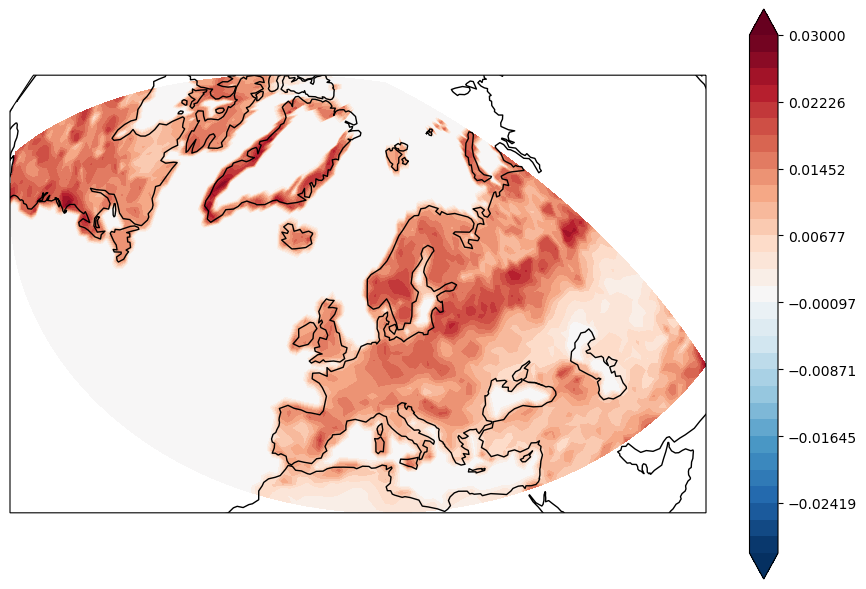

In [19]:
LON, LAT = ln.np.meshgrid(lon, lat)
import cartopy.crs as ccrs
import general_purpose.cartopy_plots as cplt
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(9,6))
cplt.multiple_field_plot2(LON, LAT, np.std(X,0)[...,2:3],projections=[ccrs.Orthographic(10, 55)],
                         fig_num=8, put_colorbar=True, use_norm=False, levs=np.linspace(-0.03,0.03,32),
                         extents=[None, None, (-5, 10, 39, 60)],
                         mode='contourf',draw_labels=False,draw_gridlines=False,
                        )

In [20]:
X

array([[[[-6.36078060e-01, -2.69282017e+01, -1.01969074e-02],
         [-9.07077253e-01, -2.41526661e+01, -1.21535044e-02],
         [-6.18973374e-01, -2.30016041e+01, -1.73668459e-03],
         ...,
         [-6.68060541e+00, -8.60283890e+01, -3.66546307e-03],
         [-6.19369411e+00, -9.13124695e+01, -1.84109341e-02],
         [-5.51650953e+00, -9.20661545e+01, -2.38648597e-02]],

        [[-1.08578575e+00, -2.34237576e+01, -5.19251730e-03],
         [-1.06578076e+00, -1.96126785e+01, -1.06235743e-02],
         [-2.28443787e-01, -1.72565403e+01, -1.16436016e-02],
         ...,
         [-6.94973850e+00, -9.56854935e+01, -6.94241980e-03],
         [-6.70835209e+00, -1.03075432e+02, -1.30557846e-02],
         [-6.31644249e+00, -1.04299698e+02, -1.71639044e-02]],

        [[-1.74375319e+00, -1.86461983e+01, -1.03693977e-02],
         [-1.57187068e+00, -1.47990389e+01, -6.46797242e-03],
         [-3.67267102e-01, -1.10154343e+01, -1.31579926e-02],
         ...,
         [-7.45344400e+0

norm = <matplotlib.colors.TwoSlopeNorm object at 0x7f626e4560a0>


<GeoAxesSubplot:>

<Figure size 900x600 with 0 Axes>

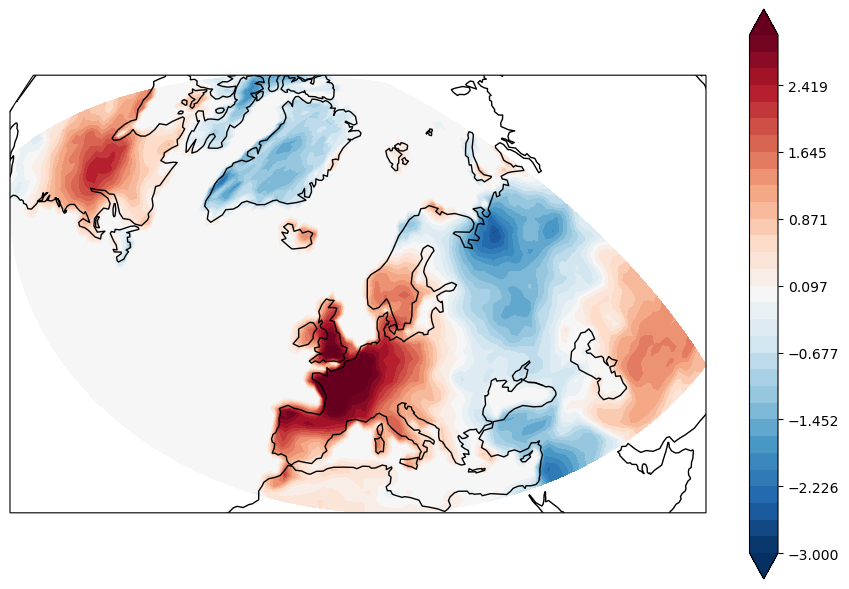

In [7]:
fig = plt.figure(figsize=(9,6))
cplt.multiple_field_plot2(LON, LAT, np.mean(X[Y==1],0)[...,0:1],projections=[ccrs.Orthographic(10, 55)],
                         fig_num=8, put_colorbar=True, use_norm=False, levs=np.linspace(-3,3,32),
                         extents=[None, None, (-5, 10, 39, 60)],
                         mode='contourf',draw_labels=False,draw_gridlines=False,
                        )

norm = <matplotlib.colors.TwoSlopeNorm object at 0x7f626e547b50>


<GeoAxesSubplot:>

<Figure size 900x600 with 0 Axes>

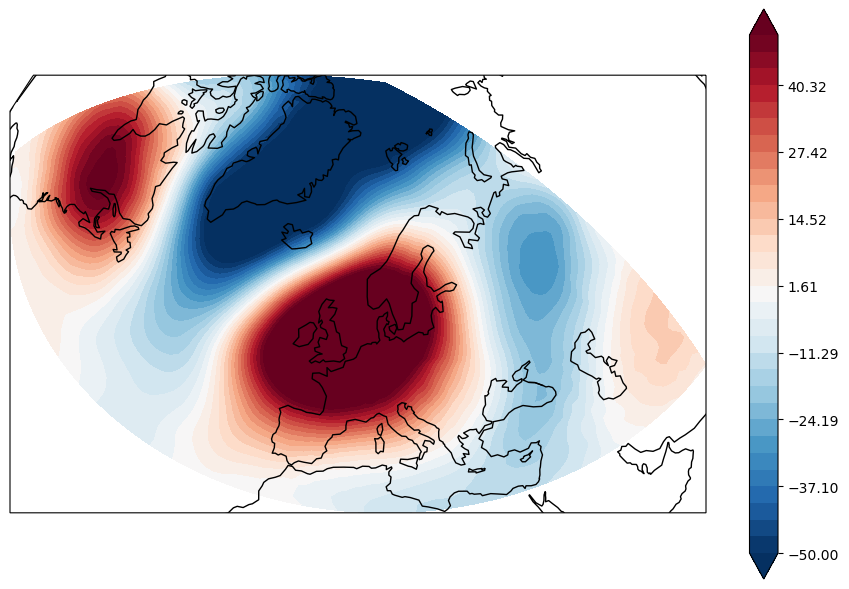

In [8]:
fig = plt.figure(figsize=(9,6))
cplt.multiple_field_plot2(LON, LAT, np.mean(X[Y==1],0)[...,1:2],projections=[ccrs.Orthographic(10, 55)],
                         fig_num=8, put_colorbar=True, use_norm=False, levs=np.linspace(-50,50,32),
                         extents=[None, None, (-5, 10, 39, 60)],
                         mode='contourf',draw_labels=False,draw_gridlines=False,
                        )

norm = <matplotlib.colors.TwoSlopeNorm object at 0x7f626e300370>


<GeoAxesSubplot:>

<Figure size 900x600 with 0 Axes>

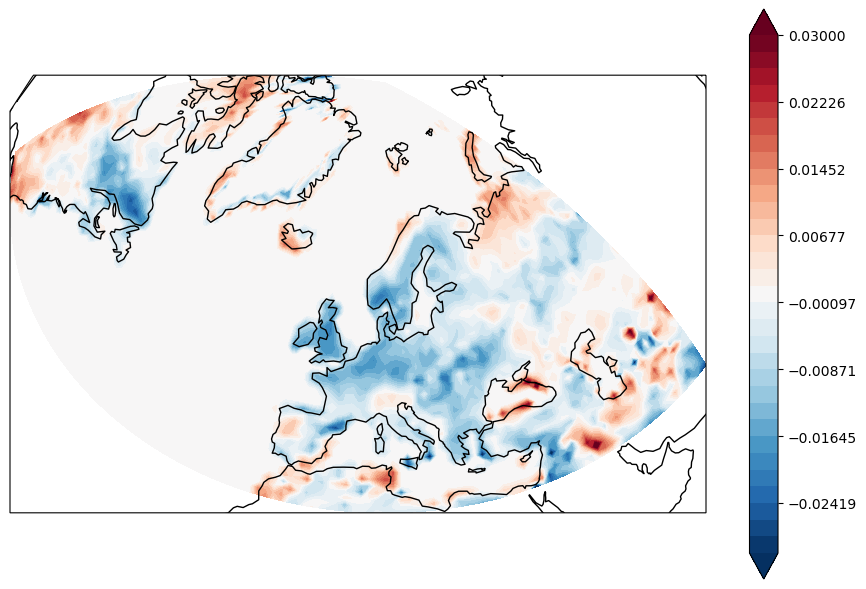

In [9]:
fig = plt.figure(figsize=(9,6))
cplt.multiple_field_plot2(LON, LAT, np.mean(X[Y==1],0)[...,2:3],projections=[ccrs.Orthographic(10, 55)],
                         fig_num=8, put_colorbar=True, use_norm=False, levs=np.linspace(-.03,.03,32),
                         extents=[None, None, (-5, 10, 39, 60)],
                         mode='contourf',draw_labels=False,draw_gridlines=False,
                        )

# Working with the `Trainer` Class

Instead of using the module level functions such as `load_data` or `train_model`, you can use the `Trainer` class to a simpler training of the networks and efficient over multiple runs.

First create a `Trainer` object in a given work directory. You can avoid the work directory if don't plan to train networks

Then you can call the equivalent of module level functions `t.prepare_data`, `t.prepare_XY`, `t.load_data`. If you call them multiple times with the same arguments the values will be cached, the values will be cached so you will save time.

In [10]:
# create a work directory
work_dir = '../../Models/CESM/models/tests/test1'

if os.path.exists(work_dir):
    !rm -rf {work_dir} 
t = ln.Trainer(work_dir)
t.config_dict

Initializing config dictionary from default values
tf.__version__ = '2.6.2'
tf.config.list_physical_devices('GPU') = [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


{'run_kwargs': {'log_level': 20,
  'load_data_kwargs': {'dataset_years': 8000,
   'year_list': None,
   'sampling': '',
   'Model': 'Plasim',
   'area': 'France',
   'filter_area': 'France',
   'lon_start': -64,
   'lon_end': 64,
   'lat_start': 0,
   'lat_end': 22,
   'mylocal': '/local/gmiloshe/PLASIM/',
   'fields': ['t2m', 'zg500', 'mrso_filtered'],
   'preprefix': 'ANO_',
   'datafolder': 'Data_Plasim'},
  'prepare_XY_kwargs': {'do_premix': False,
   'premix_seed': 0,
   'do_balance_folds': True,
   'nfolds': 10,
   'year_permutation': None,
   'flatten_time_axis': True,
   'return_time_series': False,
   'make_XY_kwargs': {'label_field': 't2m',
    'time_start': 30,
    'time_end': 120,
    'T': 14,
    'tau': 0,
    'percent': 5,
    'threshold': None,
    'label_period_start': None,
    'label_period_end': None,
    'A_weights': None,
    'return_threshold': False},
   'roll_X_kwargs': {'roll_axis': 'lon', 'roll_steps': 0}},
  'k_fold_cross_val_kwargs': {'load_from': 'last',
  

Rewriting the config file to make it consistent with CESM and simplifying architecture to use only three dense layers

In [11]:
import itertools as its

Months1 = [0, 0, 0, 0, 0, 0, 31, 30, 31, 31, 30, 0, 0, 0] # Because of 3 day running mean we lose 2 days
Tot_Mon1 = list(its.accumulate(Months1))
d = {
    'conv_channels':None, #[2,2,2],
    'padding':'same',
    'max_pool_sizes':None,
    'dense_units':[8,8,2],
    'dense_activations':['relu','relu', None],
    'dense_dropouts':[0.2,0.2,False],
     #conv_skip={'0':1},
    'nfolds' : 2,
    'u': 1,
    "training_epochs": 2,
    "training_epochs_tl": 1,
    'fields': ['t2m'], 
    'year_list' : 'range(20)', 
    'mylocal' : '/net/nfs/ssd1/gmiloshe/Climate-Learning/CESM/', 
    'time_start' : Tot_Mon1[6], #-3, 
    'label_period_start' : Tot_Mon1[6],
    'time_end' : Tot_Mon1[9], # Take into account number of days per month in CESM
    'lon_start' : -8, 
    'lon_end' : 24,
    'lat_end' : 128+36, 
    'lat_start' : 128, # latitudes start from 90 degrees North Pole
    'Model' : 'CESM', 
    'datafolder' : 'Data_CESM_short', 
    'dataset_years' : 1000, 
    'preprefix' : 'North_Anomalies_',
    'load_from' : None
}

ut.set_values_recursive(t.config_dict, d, inplace=True)
print(ut.dict2str(t.config_dict))

{
    "run_kwargs": {
        "log_level": 20,
        "load_data_kwargs": {
            "dataset_years": 1000,
            "year_list": "range(20)",
            "sampling": "",
            "Model": "CESM",
            "area": "France",
            "filter_area": "France",
            "lon_start": -8,
            "lon_end": 24,
            "lat_start": 128,
            "lat_end": 164,
            "mylocal": "/net/nfs/ssd1/gmiloshe/Climate-Learning/CESM/",
            "fields": [
                "t2m"
            ],
            "preprefix": "North_Anomalies_",
            "datafolder": "Data_CESM_short"
        },
        "prepare_XY_kwargs": {
            "do_premix": false,
            "premix_seed": 0,
            "do_balance_folds": true,
            "nfolds": 2,
            "year_permutation": null,
            "flatten_time_axis": true,
            "return_time_series": false,
            "make_XY_kwargs": {
                "label_field": "t2m",
                "time_start": 31,
 

In [12]:
t.schedule()
t.run_multiple()

Scheduling 1 run at default values
Starting 1 run
hal5: Run 1/1
Models will be trained from scratch
folder = '0'

{}
load_data:
  Opening field TSA
  First valid path found in /net/nfs/ssd1/gmiloshe/Climate-Learning/CESM/Data_CESM_short/North_Anomalies_TSA.nc
  monotonize_years:
  monotonize_years: completed in 0.0 s
  The loaded field has 20 years, not 1000 as provided. Setting self.years = 20
  First valid path found in /net/nfs/ssd1/gmiloshe/Climate-Learning/CESM/Data_CESM/CAM_landmask.nc
  First valid path found in /net/nfs/ssd1/gmiloshe/Climate-Learning/CESM/Data_CESM/CAM_cellarea.nc
  select_years:
  select_years: completed in 0.3 s
  sort_lat:
  sort_lat: completed in 0.0 s
  select_lonlat:
  select_lonlat: completed in 0.0 s
  First valid path found in /net/nfs/ssd1/gmiloshe/Climate-Learning/CESM/Data_CESM/CAM_landmask.nc
load_data: completed in 1.7 s
prepare_XY:
  return_threshold = False  
  make_XY:
     time_start = 31, time_end = 123, label_period_start = 31, label_period_

2023-03-03 08:51:11.382191: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


  
  Model: "model"
  _________________________________________________________________
  Layer (type)                 Output Shape              Param #   
  input (InputLayer)           [(None, 36, 32, 1)]       0         
  _________________________________________________________________
  flatten (Flatten)            (None, 1152)              0         
  _________________________________________________________________
  dense_layer_0 (Dense)        (None, 8)                 9224      
  _________________________________________________________________
  dense_activation_0 (Activati (None, 8)                 0         
  _________________________________________________________________
  dense_dropout_0 (Dropout)    (None, 8)                 0         
  _________________________________________________________________
  dense_layer_1 (Dense)        (None, 8)                 72        
  _________________________________________________________________
  dense_activation_1 (Activa

2023-03-03 08:51:13.795122: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22336 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:17:00.0, compute capability: 8.6
2023-03-03 08:51:14.348231: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


    Epoch 1/2    


2023-03-03 08:51:18.596092: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
/net/nfs/ssd1/miniconda3/envs/tfgpu2.6/lib/python3.9/site-packages/keras/metrics.py:254: UserWarning: Metric MCCMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '
/net/nfs/ssd1/miniconda3/envs/tfgpu2.6/lib/python3.9/site-packages/keras/metrics.py:254: UserWarning: Metric ConfusionMatrixMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '


    1/1 - 5s - loss: 0.7524 - accuracy: 0.4506 - MCC: -2.0585e-03 - UnbiasedMCC: -2.0585e-03 - confusion_matrix: 197.5000 - BrierScore: 0.2628 - CustomLoss: 0.7524 - val_loss: 0.7236 - val_accuracy: 0.4443 - val_MCC: 0.0756 - val_UnbiasedMCC: 0.0756 - val_confusion_matrix: 197.5000 - val_BrierScore: 0.2569 - val_CustomLoss: 0.7236
    
    Epoch 00001: saving model to ../../Models/CESM/models/tests/test1/0/fold_0/cp-0001.ckpt    
    
    Learning rate for epoch 1 is 0.0005000000237487257
    Epoch 2/2    
    1/1 - 0s - loss: 0.7192 - accuracy: 0.4848 - MCC: 0.0241 - UnbiasedMCC: 0.0241 - confusion_matrix: 197.5000 - BrierScore: 0.2620 - CustomLoss: 0.7192 - val_loss: 0.6950 - val_accuracy: 0.5013 - val_MCC: 0.0374 - val_UnbiasedMCC: 0.0374 - val_confusion_matrix: 197.5000 - val_BrierScore: 0.2571 - val_CustomLoss: 0.6950
    
    Epoch 00002: saving model to ../../Models/CESM/models/tests/test1/0/fold_0/cp-0002.ckpt    
    
    Learning rate for epoch 2 is 0.0005000000237487257


2023-03-03 08:51:19.478962: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


    INFO:tensorflow:Assets written to: ../../Models/CESM/models/tests/test1/0/fold_0/assets
    Assets written to: ../../Models/CESM/models/tests/test1/0/fold_0/assets
                 loss  accuracy       MCC  UnbiasedMCC  \
    epoch-1                                              
    0        0.752414  0.450633 -0.002059    -0.002059   
    1        0.719164  0.484810  0.024142     0.024142   
    
                           confusion_matrix  BrierScore  CustomLoss  val_loss  \
    epoch-1                                                                     
    0        [[334.0, 416.0], [18.0, 22.0]]    0.262785    0.752414  0.723567   
    1        [[360.0, 390.0], [17.0, 23.0]]    0.261985    0.719164  0.694997   
    
             val_accuracy   val_MCC  val_UnbiasedMCC  \
    epoch-1                                            
    0            0.444304  0.075642         0.075642   
    1            0.501266  0.037445         0.037445   
    
                       val_confusion_

/net/nfs/ssd1/miniconda3/envs/tfgpu2.6/lib/python3.9/site-packages/keras/metrics.py:254: UserWarning: Metric MCCMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '
/net/nfs/ssd1/miniconda3/envs/tfgpu2.6/lib/python3.9/site-packages/keras/metrics.py:254: UserWarning: Metric ConfusionMatrixMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '


    1/1 - 1s - loss: 0.6866 - accuracy: 0.5949 - MCC: 0.0065 - UnbiasedMCC: 0.0065 - confusion_matrix: 197.5000 - BrierScore: 0.2750 - CustomLoss: 0.6866 - val_loss: 0.5879 - val_accuracy: 0.7722 - val_MCC: 0.0651 - val_UnbiasedMCC: 0.0651 - val_confusion_matrix: 197.5000 - val_BrierScore: 0.2651 - val_CustomLoss: 0.5879
    
    Epoch 00001: saving model to ../../Models/CESM/models/tests/test1/0/fold_1/cp-0001.ckpt    
    
    Learning rate for epoch 1 is 0.0005000000237487257
    Epoch 2/2    
    1/1 - 0s - loss: 0.6525 - accuracy: 0.6443 - MCC: 0.0083 - UnbiasedMCC: 0.0083 - confusion_matrix: 197.5000 - BrierScore: 0.2724 - CustomLoss: 0.6525 - val_loss: 0.5687 - val_accuracy: 0.8127 - val_MCC: 0.0413 - val_UnbiasedMCC: 0.0413 - val_confusion_matrix: 197.5000 - val_BrierScore: 0.2662 - val_CustomLoss: 0.5687
    
    Epoch 00002: saving model to ../../Models/CESM/models/tests/test1/0/fold_1/cp-0002.ckpt    
    
    Learning rate for epoch 2 is 0.0005000000237487257
    INFO:tenso